In [ ]:
!pip install xgboost
import pandas as pd
import warnings
import numpy as np
import re
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [ ]:
df_test= pd.read_csv('test.csv')

In [ ]:
df_test.dtypes

ID               object
대출금액              int64
대출기간             object
근로기간             object
주택소유상태           object
연간소득              int64
부채_대비_소득_비율     float64
총계좌수              int64
대출목적             object
최근_2년간_연체_횟수      int64
총상환원금             int64
총상환이자           float64
총연체금액           float64
연체계좌수           float64
dtype: object

df_test_num = df_test.select_dtypes(include=['float64','int64'])
df_test_num.hist(figsize=(17, 22), bins=50, xlabelsize=8, ylabelsize=8);
#대출금,액 연간소득, 부채소비 비율, 총계좌수
# 최근 2년간 연체 횟수, 총상환원금,총상환이자, 총연체금액


In [ ]:
df_train =pd.read_csv('train.csv')


for i,col_name in enumerate(df_train.columns):
  print(df_train.columns[i],df_train[col_name].unique())




ID ['TRAIN_00000' 'TRAIN_00001' 'TRAIN_00002' ... 'TRAIN_96291' 'TRAIN_96292'
 'TRAIN_96293']
대출금액 [12480000 14400000 12000000 ...  1650000 36240000 39450000]
대출기간 [' 36 months' ' 60 months']
근로기간 ['6 years' '10+ years' '5 years' '8 years' 'Unknown' '9 years' '2 years'
 '1 year' '3 years' '7 years' '4 years' '< 1 year' '10+years' '<1 year'
 '3' '1 years']
주택소유상태 ['RENT' 'MORTGAGE' 'OWN' 'ANY']
연간소득 [ 72000000 130800000  96000000 ...  78602400  83094000  66330000]
부채_대비_소득_비율 [18.9  22.33  8.6  ... 63.64 71.4  52.8 ]
총계좌수 [ 15  21  14  19  30  22  45  11  26  10  24  17  35  20   9  36  16  59
  29  12  28  31   8  37   6   7  13  25  46  18  42  32  63  38  43  23
  39  33  27  76   5  40  41  50  55  61  51  53  52  62  81  34  47  48
  44   4  64  56  54  67  49  72  69  57  66  73  65 101  58  85  86  97
  60  71  70  78  75  68  79  77  95  84  74  80  90  93  96  89  91  94
  82  87 109 130 102 105  92  99 127 106  98  83 169 140 151  88 125 112
 110]
대출목적 ['부채 통합' '주택 개선' '주요 구매'

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler_standard = StandardScaler()
# df_train['연간소득'] = scaler_standard.fit_transform(df_train[['연간소득']])
from sklearn.preprocessing import RobustScaler

scaler_robust = RobustScaler()
df_train['대출금액'] = scaler_robust.fit_transform(df_train[['대출금액']])
# Log Transformation

df_train['최근_2년간_연체_횟수'] = np.log1p(df_train['최근_2년간_연체_횟수'])

scaler_minmax = MinMaxScaler()
df_train['총상환원금'] = scaler_minmax.fit_transform(df_train[['총상환원금']])
df_train['연간소득'] = scaler_minmax.fit_transform(df_train[['연간소득']])
df_train['총상환이자'] = scaler_minmax.fit_transform(df_train[['총상환이자']])
df_train['총연체금액'] = scaler_minmax.fit_transform(df_train[['총연체금액']])

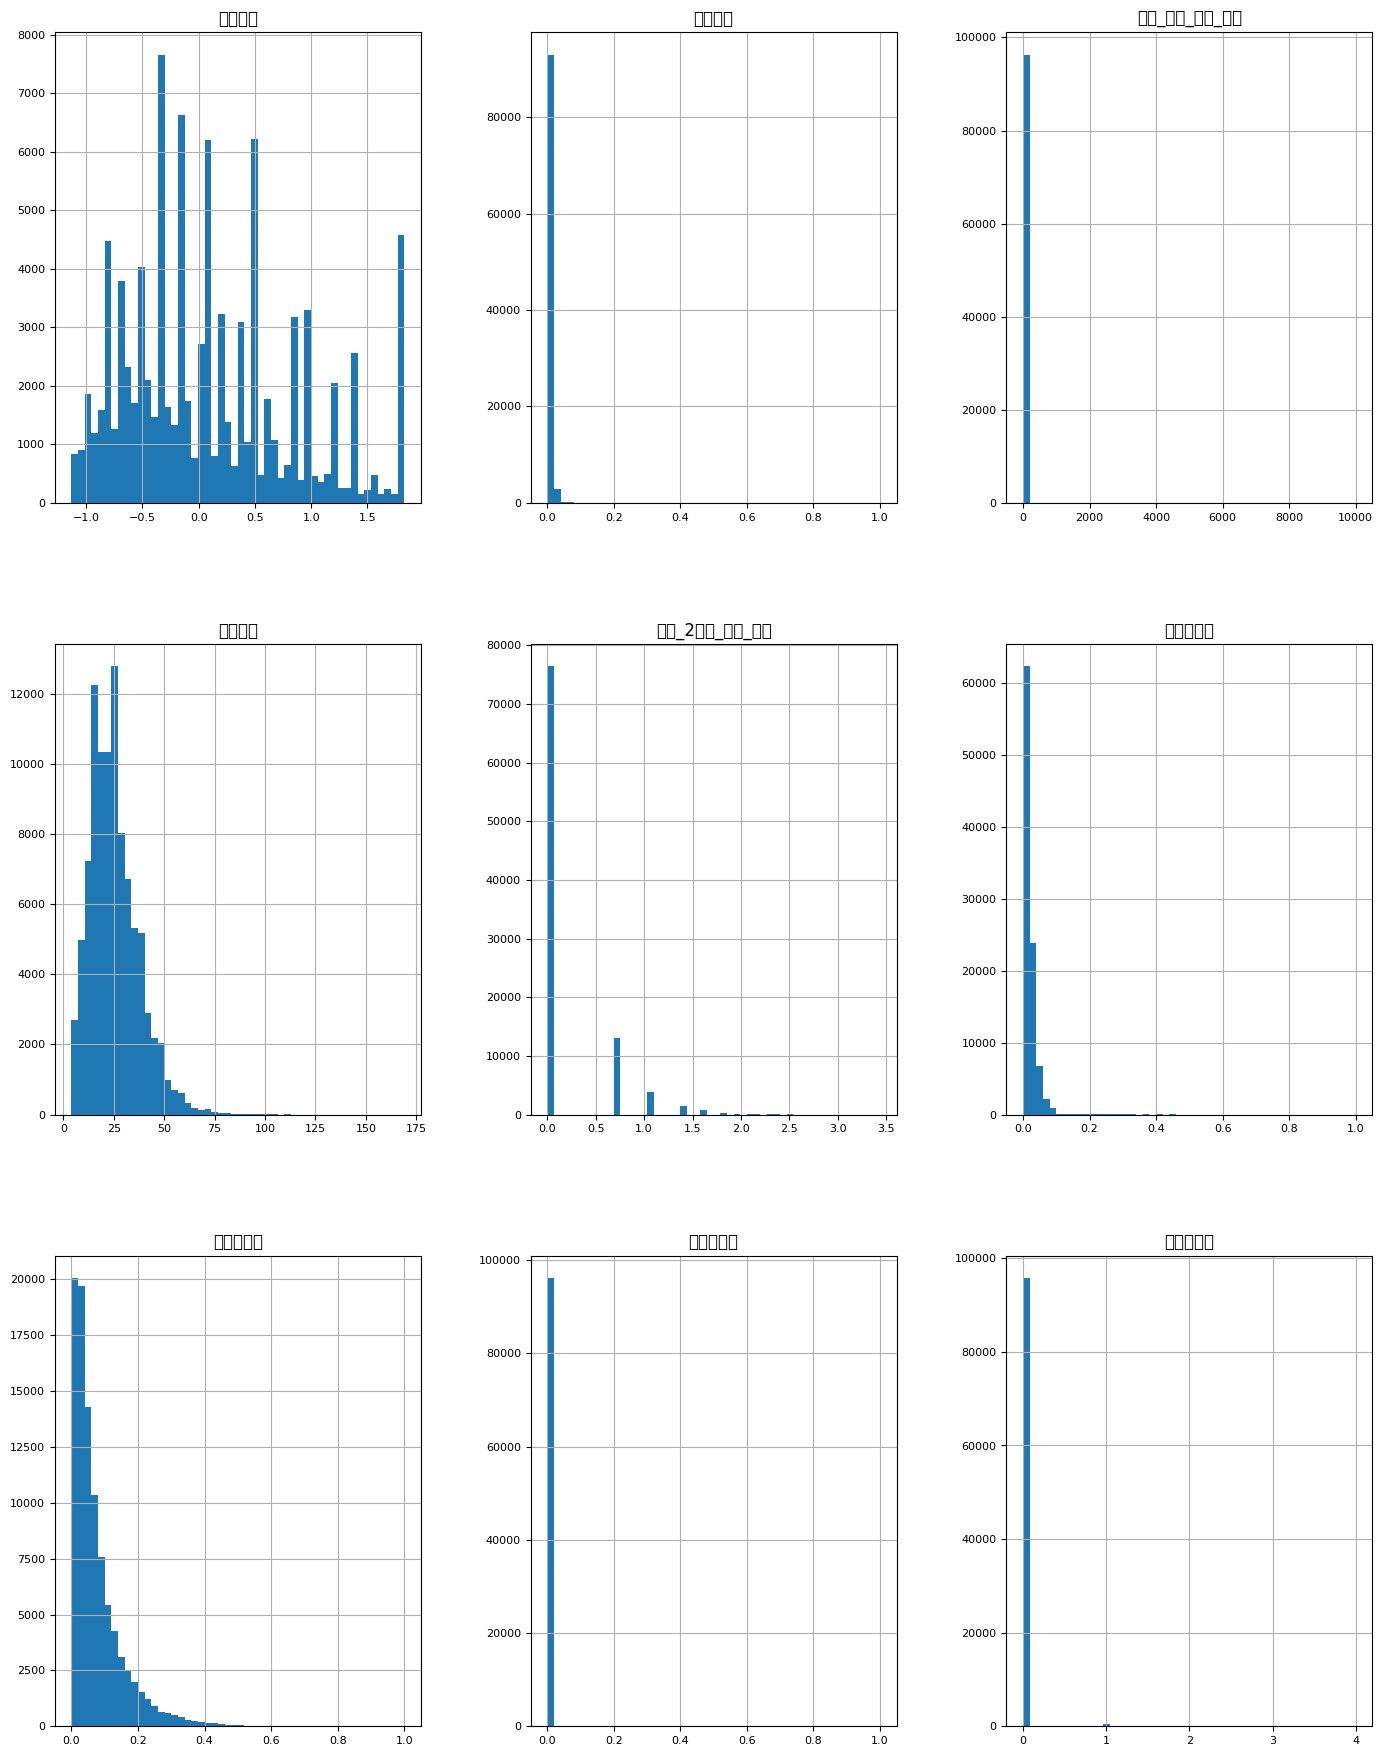

In [ ]:
df_train_num = df_train.select_dtypes(include=['float64','int64'])
df_train_num.hist(figsize=(17, 22), bins=50, xlabelsize=8, ylabelsize=8);
#대출금,액 연간소득, 부채소비 비율, 총계좌수
# 최근 2년간 연체 횟수, 총상환원금,총상환이자, 총연체금액

In [ ]:
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
n1 = len(df_train)

In [ ]:
n1

96294

In [ ]:
numeric_values = df['근로기간'].apply(lambda x: int(re.sub(r'\D', '', x)) if pd.notna(x) and re.sub(r'\D', '', x).isdigit() else None)
mean_value = numeric_values.mean()

# 'working_year' 열 추가 및 값 대입 (unknown은 평균값으로 처리)
df['working_year'] = numeric_values.fillna(mean_value)
df['근로기간'] = df.working_year

In [ ]:
df

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,working_year
0,TRAIN_00000,-3.130435e-01,36 months,6.000000,RENT,6.666667e-03,18.90,15,부채 통합,0.0,0.000000e+00,0.000000e+00,0.0,0.0,C,6.000000
1,TRAIN_00001,-1.739130e-01,60 months,10.000000,MORTGAGE,1.211111e-02,22.33,21,주택 개선,0.0,8.903913e-03,4.140152e-02,0.0,0.0,B,10.000000
2,TRAIN_00002,-3.478261e-01,36 months,5.000000,MORTGAGE,8.888889e-03,8.60,14,부채 통합,0.0,2.213379e-02,2.687649e-02,0.0,0.0,A,5.000000
3,TRAIN_00003,-1.739130e-01,36 months,8.000000,MORTGAGE,1.222222e-02,15.09,15,부채 통합,0.0,7.765862e-03,2.708239e-02,0.0,0.0,C,8.000000
4,TRAIN_00004,8.695652e-02,60 months,6.095775,RENT,6.642222e-03,25.39,19,주요 구매,0.0,5.447143e-03,2.634796e-02,0.0,0.0,B,6.095775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160486,TEST_64192,3.000000e+07,36 months,3.000000,MORTGAGE,7.800000e+07,22.08,27,부채 통합,2.0,1.307532e+06,7.633800e+05,0.0,0.0,NaN,3.000000
160487,TEST_64193,3.000000e+07,60 months,10.000000,MORTGAGE,1.092000e+08,12.06,26,부채 통합,0.0,9.606120e+05,1.245252e+06,0.0,0.0,NaN,10.000000
160488,TEST_64194,6.120000e+06,36 months,10.000000,RENT,3.960000e+07,28.80,33,부채 통합,0.0,1.315200e+05,8.088000e+04,0.0,0.0,NaN,10.000000
160489,TEST_64195,1.152000e+07,36 months,10.000000,MORTGAGE,6.600000e+07,25.44,41,부채 통합,1.0,1.339536e+06,6.018720e+05,0.0,0.0,NaN,10.000000


In [ ]:
#df = df[~df['근로기간'].isin(['Unknown'])]
print(df.head(1))
df=df.drop(columns=['총계좌수','연체계좌수','대출목적','working_year'])
new_columns = {"대출금액": "loan_amount",'대출기간':'loan_period','근로기간':'working_year','주택소유상태':'property','연간소득':'incomeyear','부채_대비_소득_비율':'DTI','대출목적':'purpose_loan','최근_2년간_연체_횟수':'overdue_num','총상환원금':'total_repayment','총상환이자':'total_interest','총연체금액':'overdue_amount','대출등급':'Rank'}
df.rename(columns = new_columns,inplace=True)

df['property'] = df['property'].apply(lambda t: {np.nan:-1, 'RENT':1, 'MORTGAGE':2, 'OWN':3, 'ANY':4}[t]).astype(np.int8)
#df['loan_period'] = df['loan_period'].apply(lambda x: re.sub(r'\D', '', x))
#df['working_year'] = df['working_year'].apply(lambda x: re.sub(r'\D', '', x))
#r'\D' 숫자가 아닌 모든 문자
#df['working_year_numeric'] = df['working_year'].str.extract('(\d+)')




            ID      대출금액        대출기간  근로기간 주택소유상태      연간소득  부채_대비_소득_비율  \
0  TRAIN_00000 -0.313043   36 months   6.0   RENT  0.006667         18.9   

   총계좌수   대출목적  최근_2년간_연체_횟수  총상환원금  총상환이자  총연체금액  연체계좌수 대출등급  working_year  
0    15  부채 통합           0.0    0.0    0.0    0.0    0.0    C           6.0  


In [ ]:
df['working_year'] = df['working_year'].apply(lambda x: '10+years' if x == '10+ years' else x)
df['working_year'] = df['working_year'].apply(lambda x: '<1 year' if x == '< 1 year' else x)
df['working_year'] = df['working_year'].apply(lambda x: '1 years' if x == '1 year' else x)


In [ ]:
df['working_year'].unique()

array([ 6.        , 10.        ,  5.        ,  8.        ,  6.09577498,
        9.        ,  2.        ,  1.        ,  3.        ,  7.        ,
        4.        ])

In [ ]:


# 가상의 데이터 생성
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 라벨 인코딩 수행
df['loan_period'] = label_encoder.fit_transform(df['loan_period'])
df['working_year'] = label_encoder.fit_transform(df['working_year'])
df['overdue_amount'] = label_encoder.fit_transform(df['overdue_amount'])
df['Rank'] = label_encoder.fit_transform(df['Rank'])


In [ ]:
df.isna().sum()

ID                 0
loan_amount        0
loan_period        0
working_year       0
property           0
incomeyear         0
DTI                0
overdue_num        0
total_repayment    0
total_interest     0
overdue_amount     0
Rank               0
dtype: int64

In [ ]:
df.Rank.unique()

array([2, 1, 0, 3, 5, 6, 4, 7])

In [ ]:
df

,ID,loan_amount,loan_period,working_year,property,incomeyear,DTI,overdue_num,total_repayment,total_interest,overdue_amount,Rank
0,TRAIN_00000,-3.130435e-01,0,5,1,6.666667e-03,18.90,0.0,0.000000e+00,0.000000e+00,0,2
1,TRAIN_00001,-1.739130e-01,1,10,2,1.211111e-02,22.33,0.0,8.903913e-03,4.140152e-02,0,1
2,TRAIN_00002,-3.478261e-01,0,4,2,8.888889e-03,8.60,0.0,2.213379e-02,2.687649e-02,0,0
3,TRAIN_00003,-1.739130e-01,0,8,2,1.222222e-02,15.09,0.0,7.765862e-03,2.708239e-02,0,2
4,TRAIN_00004,8.695652e-02,1,6,1,6.642222e-03,25.39,0.0,5.447143e-03,2.634796e-02,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
160486,TEST_64192,3.000000e+07,0,2,2,7.800000e+07,22.08,2.0,1.307532e+06,7.633800e+05,0,7
160487,TEST_64193,3.000000e+07,1,10,2,1.092000e+08,12.06,0.0,9.606120e+05,1.245252e+06,0,7
160488,TEST_64194,6.120000e+06,0,10,1,3.960000e+07,28.80,0.0,1.315200e+05,8.088000e+04,0,7
160489,TEST_64195,1.152000e+07,0,10,2,6.600000e+07,25.44,1.0,1.339536e+06,6.018720e+05,0,7


In [ ]:
train = df[:96294]
test = df[96294:]

In [ ]:
length = len(df[df['ID'].str.contains('TRAIN')])
length

96294

In [ ]:
import torch

In [ ]:
torch.tensor

<function torch._VariableFunctionsClass.tensor>

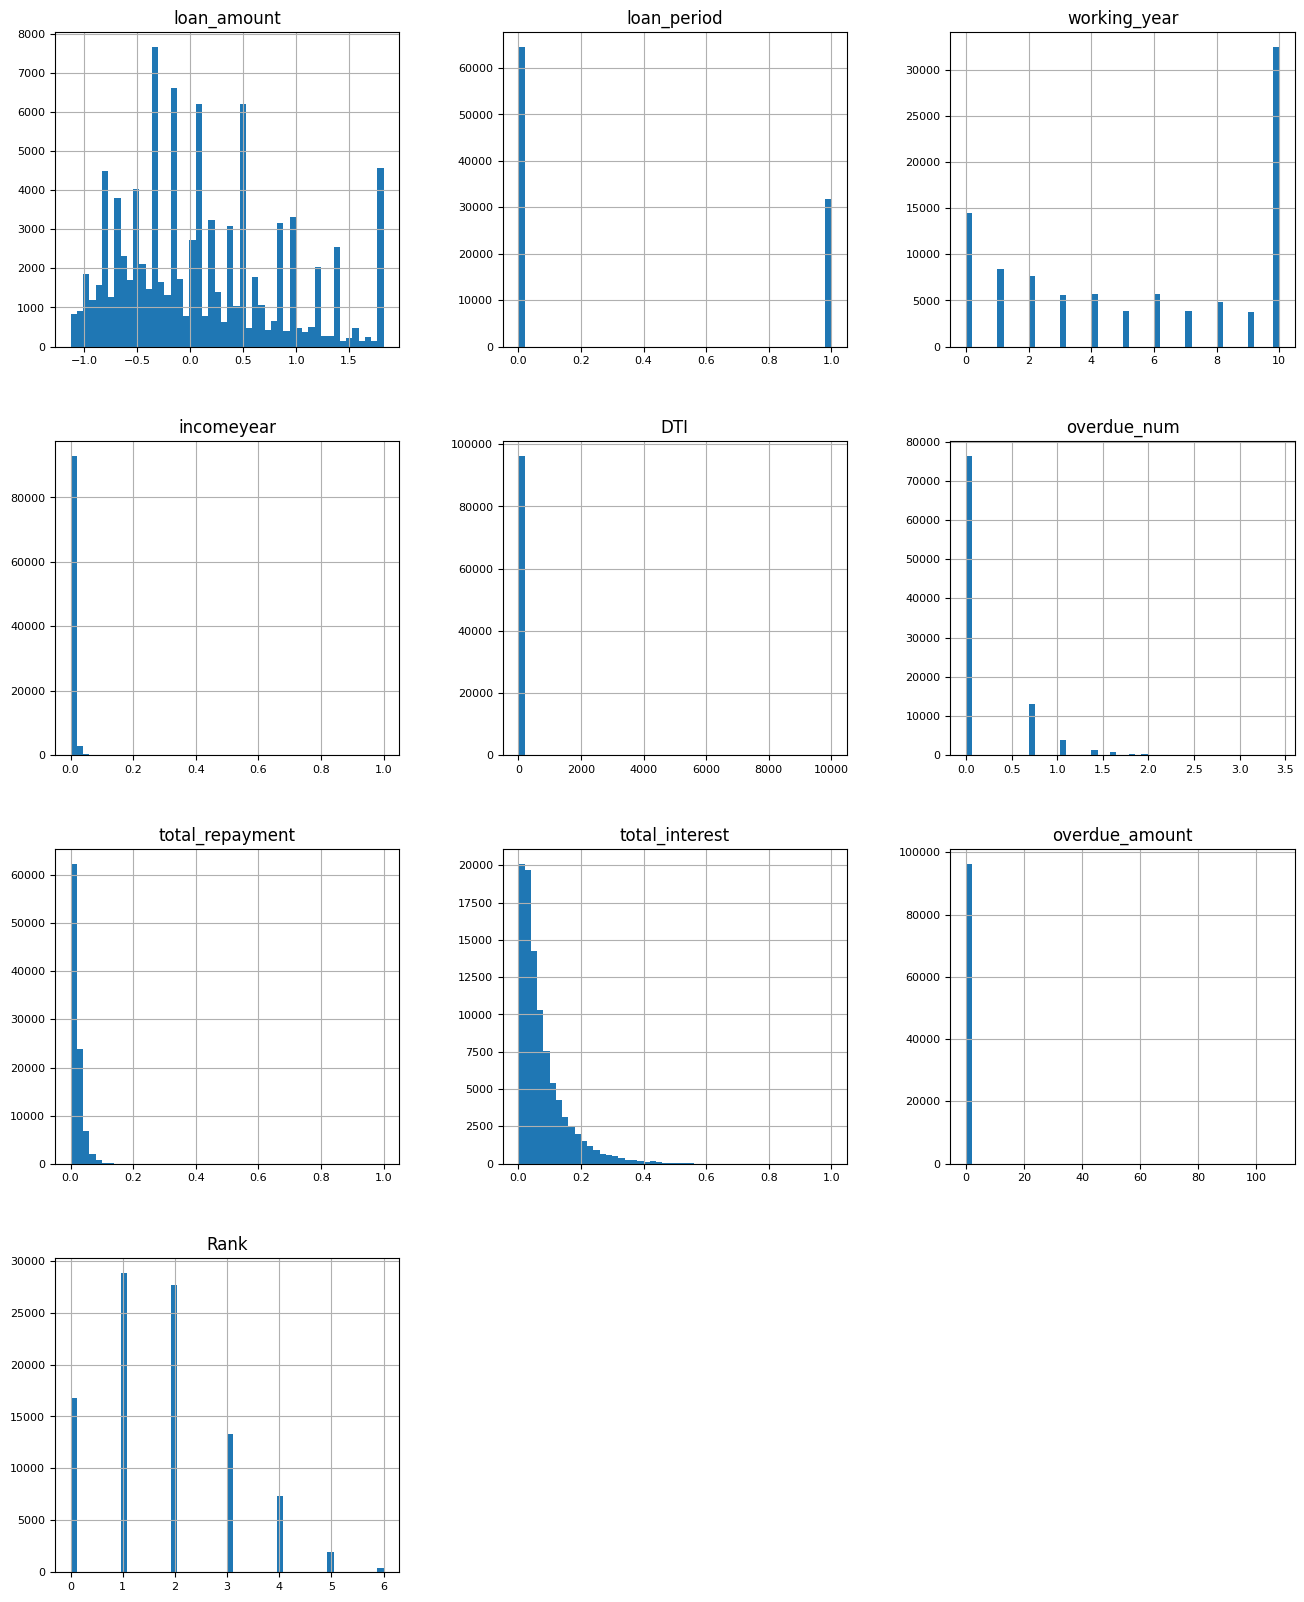

In [ ]:
df_train_num = train.select_dtypes(include = ['float64', 'int64'])

df_train_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
#대출금,액 연간소득, 부채소비 비율, 총계좌수
# 최근 2년간 연체 횟수, 총상환원금,총상환이자, 총연체금액

In [ ]:
test

,ID,loan_amount,loan_period,working_year,property,incomeyear,DTI,overdue_num,total_repayment,total_interest,overdue_amount,Rank
96294,TEST_00000,16800000.0,0,8,2,132000000.0,19.64,0.0,394692.0,146604.0,0,7
96295,TEST_00001,8400000.0,0,4,1,89971200.0,15.84,0.0,0.0,0.0,0,7
96296,TEST_00002,17280000.0,0,5,1,150000000.0,8.41,0.0,1786980.0,281820.0,0,7
96297,TEST_00003,14400000.0,0,4,2,66000000.0,13.72,1.0,669024.0,281724.0,0,7
96298,TEST_00004,27600000.0,0,4,1,55200000.0,30.50,0.0,1250052.0,614844.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
160486,TEST_64192,30000000.0,0,2,2,78000000.0,22.08,2.0,1307532.0,763380.0,0,7
160487,TEST_64193,30000000.0,1,10,2,109200000.0,12.06,0.0,960612.0,1245252.0,0,7
160488,TEST_64194,6120000.0,0,10,1,39600000.0,28.80,0.0,131520.0,80880.0,0,7
160489,TEST_64195,11520000.0,0,10,2,66000000.0,25.44,1.0,1339536.0,601872.0,0,7


In [ ]:
train=train.drop(['ID'],axis=1)
test=test.drop(['ID'],axis=1)

In [ ]:
train.shape

(96294, 11)

In [ ]:
for _, row in train.iterrows():
  tensor=torch.tensor(row.values, dtype=torch.float32).reshape(1, -1)

In [ ]:
tensor

tensor([[-5.9130e-01,  0.0000e+00,  1.0000e+01,  1.0000e+00,  4.6667e-03,
          1.1800e+01,  0.0000e+00,  1.4209e-02,  4.8635e-02,  0.0000e+00,
          2.0000e+00]])

In [ ]:
train_tensor_list = [torch.tensor(row.values, dtype=torch.float32).view(1, -1) for _, row in train.iterrows()]

# 결과 확인



In [ ]:
train_tensor = torch.cat(train_tensor_list, dim=0)

In [ ]:
train_tensor.shape

torch.Size([96294, 11])

In [ ]:
import torch.nn as nn

In [ ]:
model = nn.Sequential()

df_train_num = df_train.select_dtypes(include = ['float64', 'int64'])

df_train_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [ ]:
xtr = train.drop(columns=['Rank'])
ytr = train.Rank

In [ ]:
xtest= test.drop(columns=['Rank'])
ytest = test.Rank

RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
xtr, xtest, ytr, ytest = \
train_test_split(X, y, random_state=0, test_size=0.2)

In [ ]:


dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, nan: 7}

In [ ]:
num = {}
for i in df['Rank']:
    num[i] = num.get(i, 0) + 1

print(num)

print(len(df['Rank']))

{2: 27623, 1: 28817, 0: 16772, 3: 13354, 5: 1954, 6: 420, 4: 7354, 7: 64197}
160491


In [ ]:
for i in xtest.columns:
  xtest[i].unique()

In [ ]:
xtest.dtypes == xtr.dtypes

loan_amount        True
loan_period        True
working_year       True
property           True
incomeyear         True
DTI                True
overdue_num        True
total_repayment    True
total_interest     True
overdue_amount     True
dtype: bool

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(xtr, ytr, random_state=0, test_size=0.2)

# xtr_eval, xtest_eval, ytr_eval, ytest_eval = train_test_split(xtr, ytr, random_state=0, test_size=0.2)


User

*   List item
*   List item


XGBClassifier 클래스의 모든 주요 매개변수는 다음과 같습니다:

booster (부스터 유형):

트리 부스팅 모델의 종류를 지정합니다. "gbtree"는 트리 기반 부스팅을, "gblinear"는 선형 모델 기반 부스팅을, "dart"는 향상된 부스팅을, "gpu_hist"는 GPU 지원 히스토그램 기반 부스팅을 나타냅니다. 기본값은 "gbtree"입니다.
n_estimators (트리의 개수):

부스팅 프로세스에서 생성할 트리의 총 개수입니다.
learning_rate (학습률):

각 트리의 기여도를 제어하는 학습률입니다.
max_depth (트리의 최대 깊이):

각 트리의 최대 깊이를 제한하여 과적합을 방지합니다.
subsample (트리를 훈련할 때 사용하는 데이터의 일부):

각 트리를 훈련할 때 사용할 데이터의 비율을 지정합니다.
colsample_bytree (각 트리에서 사용할 특성의 비율):

각 트리를 훈련할 때 사용할 특성의 비율을 지정합니다.
gamma (트리 분할을 위한 최소 손실 감소량):

이 값보다 손실이 적게 감소하는 분할은 수행되지 않습니다.
min_child_weight (최소 자식 노드의 가중치 합 제한):

리프 노드의 가중치 합이 이 값보다 작아야 추가 분할이 수행됩니다.
objective (최적화 목적 함수):

모델이 최적화하는 목적 함수를 지정합니다. "reg:squarederror"는 회귀, "binary:logistic"은 이진 분류, "multi:softmax"는 다중 클래스 분류 등이 있습니다.
reg_alpha (L1 정규화 강도):

가중치에 대한 L1 정규화 강도를 조절합니다.
reg_lambda (L2 정규화 강도):

가중치에 대한 L2 정규화 강도를 조절합니다.
scale_pos_weight (양성 클래스의 가중치):

불균형한 클래스 문제에 대한 가중치를 조절합니다.
base_score (기본 예측값):

초기 예측값을 설정합니다.
random_state (랜덤 시드):

모델을 재현 가능하게 만들기 위한 랜덤 시드를 지정합니다.
use_label_encoder (레이블 인코딩 사용 여부):


scale_pos_weight 계산:
scale_pos_weight는 Negative 클래스의 비율을 Positive 클래스의 비율로 나눈 값

양성 클래스가 10%의 샘플을 차지하고 음성 클래스가 90%의 샘플을 차지 scale_pos_weight는 90% / 10% = 9



xgb_clf = xgb.XGBClassifier(seed=42,
                            use_label_encoder=False,
                            n_estimators=1500, #3000
                            num_boost_round=100,
                            objective='multi:softmax',
                            num_classes =7,#binary:logistic
                            gammma=1, #0.05
                            missing=0,
                            booster='gbtree',
                            scale_pos_weight=0.3,
                            min_child_weight=3, #작은 데이터셋에서는 노이즈와 이상치에 민감할수 있으니 큰값
                            learn_rate=0.02,
                            #grow_policy='lossguide',
                            max_depth =15, #작을수록 트리 간단해짐,소규모 df에는 큰 값
                            reg_lambda=3, #정규화 강화 초기값0.1~1.0
                            sub_sample = 0.7, #전체데이터 90퍼사용
                            colsample_bytree=0.7,
                            n_jobs=1)
# xgb_clf.fit(X_train,
#             y_train,
#             verbose=True,
#             eval_metric='aucpr',
#             early_stopping_rounds=15,
#             eval_set = [(X_test,y_test)])



from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)
krr.fit(xtr,ytr)

In [ ]:

from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)


In [ ]:
xgb = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV( alphas=alphas2, random_state=42, cv=kfolds))
# elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [ ]:
lightgbm = LGBMRegressor(objective='regression',
                                       num_leaves=4,
                                       learning_rate=0.01,
                                       n_estimators=5000,
                                       max_bin=200,
                                       bagging_fraction=0.75,
                                       bagging_freq=5,
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, gbr, xgb, lightgbm),
                                meta_regressor=xgb,
                                use_features_in_secondary=True)

In [ ]:
import numpy as np

In [ ]:

print('stack_gen')
stack_gen_model = stack_gen.fit(xtr,ytr)

# print('elasticnet')
# elastic_model_full_data = elasticnet.fit(xtr, ytr,max_iter=1000000)

print('Lasso')
lasso_model_full_data = lasso.fit(xtr, ytr)

print('Ridge')
ridge_model_full_data = ridge.fit(xtr, ytr)

print('Svr')
svr_model_full_data = svr.fit(xtr, ytr)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(xtr, ytr)

print('xgboost')
xgb_model_full_data = xgb.fit(xtr, ytr)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(xtr, ytr)

stack_gen
Lasso
Ridge
Svr
GradientBoosting


stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
def blend_models_predict(xtr):
    return (
            (0.05 * lasso_model_full_data.predict(xtr)) + \
            (0.1 * ridge_model_full_data.predict(xtr)) + \
            (0.15 * svr_model_full_data.predict(xtr)) + \
            (0.15 * gbr_model_full_data.predict(xtr)) + \
            (0.15 * xgb_model_full_data.predict(xtr)) + \
            (0.1 * lgb_model_full_data.predict(xtr)) + \
            (0.3 * stack_gen_model.predict(np.array(xtr))))

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = blend_models_predict(xtr)


xgb_clf.fit(xtr,
            ytr,
            verbose=True)

y_pred = xgb_clf.predict(xtest)

y_pred

In [ ]:
len(y_pred)

In [ ]:
len(xtest)

In [ ]:
decoded_labels = label_encoder.inverse_transform(y_pred)


In [ ]:
df2 = pd.read_csv('sample_submission.csv')

In [ ]:
df2['대출등급']=decoded_labels

In [ ]:
df2

In [ ]:
df2.to_csv('submission.csv', index=False)


In [ ]:
sample_submission['대출등급'] = y_pred